#Building a Logistic Regression Model to Predict Wine Quality


**Author: Darren Bansil**

**Date: June 19th, 2023**

We will be building our own logistic regression model from scratch. Logistic regression takes a set of independent variables and makes a prediction on an event happening or not. This makes it a great model for binary classification which is what we will be doing today. Our model will train on a variety of wine attributes and make a prediction on if the wine is of good quality or not.

**Dataset**

We will be working with a dataset on Portuguese "Vinho Verde" red wine pulled from UC Irvine Machine Learning Repository. The dataset can be found [here](https://doi.org/10.24432/C56S3T).



Input variables (based on physicochemical tests):
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Output variable (based on sensory data):
12. quality (score between 0 and 10)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

##1. Load Data + EDA

In [2]:
df = pd.read_csv('Wine_Quality_Data.csv')

In [3]:
df.head()
print(df.shape)

(6497, 13)


Let's check for any missing/null values in the dataframe.

In [4]:
df.isnull().sum()

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64

Wine quality will be the target feature. Let's look at the distribution of qualities so we can choose a good threshold for what makes a *good* quality wine.

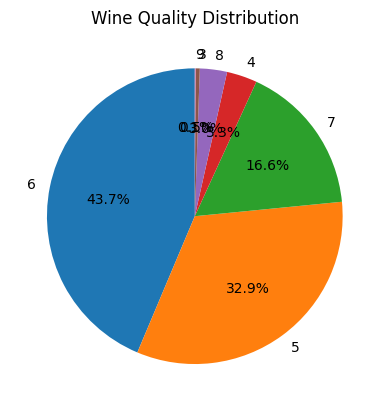

In [5]:
wine_quality = df['quality'].value_counts(normalize=True)
quality_labels = [6, 5, 7, 4, 8, 3, 9]

plt.pie(wine_quality, labels=quality_labels, startangle=90, autopct='%1.1f%%')
plt.title("Wine Quality Distribution")
plt.show()

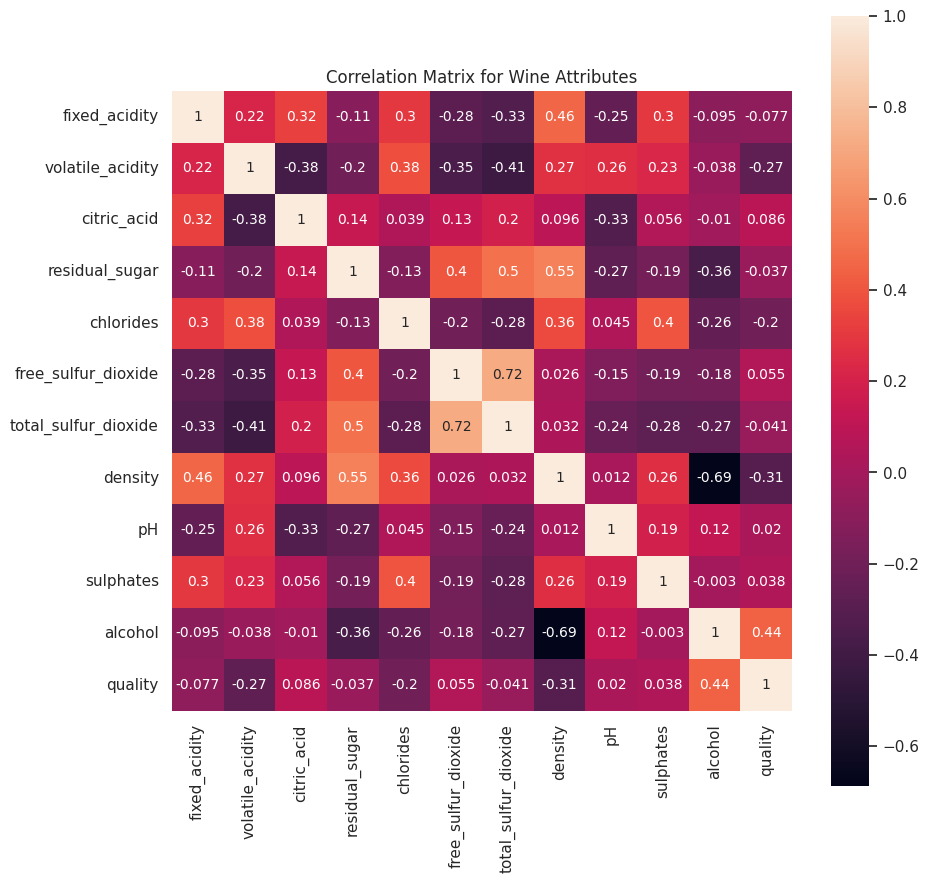

In [6]:
plt.figure(figsize=(10, 10))
sns.set(font_scale=1)
hm = sns.heatmap(df.select_dtypes(include=np.number).corr(),
                 annot=True,
                 annot_kws={'size': 10},
                 square=True)
plt.title("Correlation Matrix for Wine Attributes")

plt.show()

###Observations
*   Three quarters of the wines in the dataset were scored as a 6 or 5 level wine
*   The highest correlation between wine attributes is between free and total sulfur dioxide
*   The lowest correlation is between density and alcohol

##2. Feature Selection and Preproccessing

Before we assign our features and target, we can drop the color attribute since this dataset only contains red wines.


In [7]:
df = df.drop('color', axis=1)

We will also drop *total sulfur dioxide* since it had a materially high correlation with *free sulfur dioxide*. Dropping highly correlated variables is necessary as it prevents multicollinearity which is when it becomes too difficult to gauge the impact of each independent variable.

In [8]:
df = df.drop('total_sulfur_dioxide', axis=1)
df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,0.99114,3.27,0.50,11.2,6
6493,6.6,0.32,0.36,8.0,0.047,57.0,0.99490,3.15,0.46,9.6,5
6494,6.5,0.24,0.19,1.2,0.041,30.0,0.99254,2.99,0.46,9.4,6
6495,5.5,0.29,0.30,1.1,0.022,20.0,0.98869,3.34,0.38,12.8,7


As mentioned before, we will be using quality as our target and the rest of the attributes as our features. However, we first need to make quality a binary target. To do this, we will say wines of quality greater than six to be *good* quality wine and those less than or equal to six to be *bad* quality wine.

In [9]:
df['good_quality'] = [ 1 if x >= 7 else 0 for x in df['quality']]
y = df['good_quality']
X = df.drop(['quality', 'good_quality'], axis=1)

df['good_quality'].value_counts()

0    5220
1    1277
Name: good_quality, dtype: int64

##3. Split into Training and Test Sets


We will be running an 80:20 split between training and test sets. Setting the random state to 42 seeds the RNG so we can always reproduce the same split.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train.shape

(5197, 10)

##4. Build the Linear Regression Model

Since we will be building our Linear Regression model from scratch, we also need to write a few helper functions:
* One-hot encoder
* Cross-entropy loss
* Softmax activation



###4.1 Build the One Hot Encoder

We first need to format our target data to work with our model. To do that, we will be converting our good/bad labels into a binary matrix via one-hot encoding. The result will be a matrix with *num_samples* rows and *num_classes* columns.

In [11]:
"""
    Parameters:
    y - numpy.ndarray
        An array of labels with shape (n_samples, ).

    Returns:
    numpy.ndarray
        A matrix of one-hot encoding with shape (n_samples, n_classes).
"""
def onehot(y):
    possible_inputs = [0, 1]
    ohe = list()

    for num in y:
      value = [0 for _ in range(len(possible_inputs))]
      value[num] = 1
      ohe.append(value)

    return np.array(ohe)

###4.2 Build the Cross Entropy Loss Function

Our model needs a loss function so we have a way of tracking how well the model is improving as it is fitted to the data. Loss is inversely related to accuracy, so our loss should be decreasing with each epoch.

$\text{Cross-Entropy Loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{j=1}^n y_{ij} \log \hat{y}_{ij}$

In [12]:
"""
    Parameters:
    y_true - numpy array
        Array of true labels with shape (n_samples, n_classes).
    y_pred - numpy array
        Array of predicted labels with shape (n_samples, n_classes). Assumes y_pred is onehot encoded.

    Returns:
    float
        Cross-entropy loss between y_true and y_pred.
"""
def cross_entropy_loss(y_true, y_pred):

    y_pred_log = np.log(y_pred)
    product = y_pred_log * y_true
    logloss = -np.sum(product, axis=None) / (y_pred.shape[0] * y_pred.shape[1])

    return logloss

###4.3 Build the Softmax Activation

The predicted labels used in the loss function will come from our softmax activation function. The function will take a *scores* input and normalize it into probabilities.

$$\sigma(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{k}e^{z_j}} , \text{for } i=1,2,3,...,k $$

In [13]:
"""
    Parameters:
    scores - numpy.ndarray
        A 2D numpy array with shape (n_samples, n_classes).

    Returns:
    numpy.ndarray
        A 2D numpy array of shape (m, n) containing the probabilities of each sample belonging to each class.
"""
def softmax(scores):
    e_scores = np.exp(scores)
    return e_scores / np.sum(e_scores, axis=1)[:, None]

###4.4 Build the Model

Now we can actually build the meat of the model. We will be using a standard gradient descent algorithm to optimize our model parameters, the weights and bias.

The computation loop for each epoch will be as follows:
1. Get $scores= X_{train} W + b$
2. Use the scores to get probabilities via softmax activation
3. Use probabilities to get loss (keep track of loss)
4. Calculate the gradients
    $$\frac{\partial L}{\partial W} = -\frac{1}{m} X^T \left(y - \hat{y}\right)$$
    $$\frac{\partial L}{\partial b_j} = -\frac{1}{m} \sum_{i=1}^m \left(y_{ij} - p_{ij}\right) $$
5. Update weights and bias



In [14]:
"""
    Parameters:
    -----------
    X_train : numpy.ndarray
        The input training data with shape (num_samples, num_features).
    y_train : numpy.ndarray
        The training labels with shape (num_samples,).

    Returns:
    --------
    weights : numpy.ndarray
        The learned weights with shape (num_features, num_classes).
    bias : numpy.ndarray
        The learned bias with shape (1, num_classes).
    loss_values : list
        The list of loss values at each epoch during training.
"""

def logistic_regression(X_train, y_train):
    num_samples = X_train.shape[0]
    num_features = X_train.shape[1]
    print(y_train.shape)
    y_train = onehot(y_train)
    num_classes = y_train.shape[1]

    # initialize the weights and bias with zeros
    weights = np.zeros((num_features, num_classes))
    bias = np.zeros((1, num_classes))

    # set hyperparameters
    learning_rate = 0.1
    num_epochs = 1000

    # initialize list to keep track of the loss
    loss_values = list()

    # main computation loop
    for i in range(1, num_epochs + 1):
        scores = np.matmul(X_train, weights) + bias

        y_pred = softmax(scores)

        loss = cross_entropy_loss(y_train, y_pred)
        loss_values.append(loss)

        difference =  y_train - y_pred
        gradient_bias = -np.sum(difference, axis=0) / num_samples
        gradient_weights = -np.matmul(X_train.transpose(), difference) / num_samples

        weights = weights - (learning_rate * gradient_weights)
        bias = bias - (learning_rate * gradient_bias)

        # print loss every 50 epochs
        if i % 50 == 0:
          print("Epoch {}/{}, Loss: {:.3f}".format(i, num_epochs, loss))

    return weights, bias, loss_values

##5. Train the Model

In [15]:
weights, bias, loss_values = logistic_regression(X_train, y_train)

(5197,)
Epoch 50/1000, Loss: 0.210
Epoch 100/1000, Loss: 0.202
Epoch 150/1000, Loss: 0.200
Epoch 200/1000, Loss: 0.199
Epoch 250/1000, Loss: 0.198
Epoch 300/1000, Loss: 0.198
Epoch 350/1000, Loss: 0.198
Epoch 400/1000, Loss: 0.198
Epoch 450/1000, Loss: 0.198
Epoch 500/1000, Loss: 0.198
Epoch 550/1000, Loss: 0.198
Epoch 600/1000, Loss: 0.198
Epoch 650/1000, Loss: 0.198
Epoch 700/1000, Loss: 0.198
Epoch 750/1000, Loss: 0.198
Epoch 800/1000, Loss: 0.198
Epoch 850/1000, Loss: 0.198
Epoch 900/1000, Loss: 0.198
Epoch 950/1000, Loss: 0.198
Epoch 1000/1000, Loss: 0.198


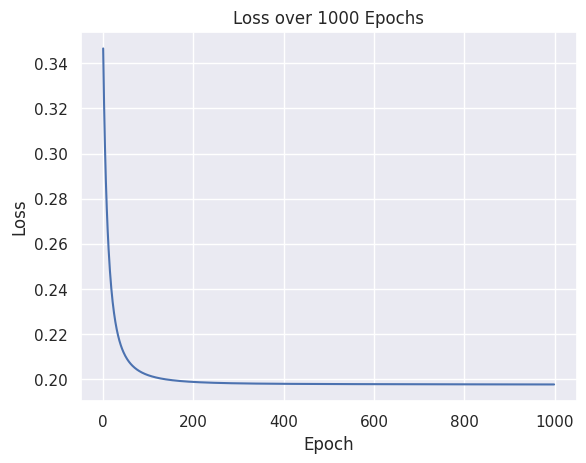

In [16]:
plt.plot(loss_values)
plt.title("Loss over 1000 Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

##6. Evaluation

Now we can use the weights and bias calculated from training to predict the wine quality from *X_test*.

In [17]:
def predict(X_test, weights, bias):
    scores = np.matmul(X_test, weights) + bias
    prob = softmax(scores)
    pred_labels = np.argmax(prob, axis=1)

    return pred_labels

In [18]:
print("Training Accuracy: ", metrics.accuracy_score(y_train, predict(X_train, weights, bias)))
print("Validation Accuracy: ", metrics.accuracy_score(y_test, predict(X_test, weights, bias)))

Training Accuracy:  0.8168173946507601
Validation Accuracy:  0.8276923076923077


Let's run sklearn's Logistic Regression model and compare it to our homemade model.

In [19]:
lr = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='multinomial')

lr.fit(X_train, y_train)

print("Training Accuracy: ", metrics.accuracy_score(y_train, lr.predict(X_train)))
print("Validation Accuracy: ", metrics.accuracy_score(y_test, lr.predict(X_test)))

Training Accuracy:  0.8185491629786416
Validation Accuracy:  0.8284615384615385


Let's also try sklearn's Random Forest Classifier just to compare to other models.

In [20]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

print("Training Accuracy: ", metrics.accuracy_score(y_train, rf.predict(X_train)))
print("Validation Accuracy: ", metrics.accuracy_score(y_test, rf.predict(X_test)))

Training Accuracy:  1.0
Validation Accuracy:  0.8830769230769231


##7. Conclusion

Awesome! Our homebrewed Logistic Regression model performed nearly the same as sklearn's model! An accuracy of ~81% is ideal. The Random Forest Classifier did even better at 87% accuracy. However, its training accuracy is showing signs of overfitting. Overfitting is when the model is too trained on specific data in the training set that it will struggle when presented with new data. Overfitting can be avoided with a fine tuned Random Forest Classifer.